In [28]:
import json
import pandas as pd
import sys
sys.path.append('../src/')
import utils.eval.rewards as rw
from utils.data.prompt_utils import qaform
from tqdm import tqdm
from statistics import mean
import matplotlib.pyplot as plt
from process_plot import loadf, makengs, plot_methods, intervmean, combineall


In [39]:
roll = pd.read_json("../outputs/results/rollouts/math/ppo_normppormbasemath.jsonl", orient='records', lines=True)

In [41]:
roll

,inputs,outputs,rewards,keepinds,selfscos,step
0,"[(((7 + 1) + 6) * 8) = , (((7 + 1) + 6) * 8) =...",[ (8 + 6) = 14 = 22 = 22 = 22 = 22\n(14 + 14) ...,"[-0.439453125, -0.373046875, 13.625, 13.0625, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0
1,"[(((6 - 9) * (9 - 6)) + ((2 - 8) * 8)) = , (((...",[ ((-3 * (9 - 6)) + ((2 - 8) * 8)) = ((-3 * 3...,"[16.75, 13.8125, 17.5, 4.59375, -6.875, 11.062...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0
2,"[(((7 * 2) * 4) - ((9 - 4) - 2)) = , (((7 * 2)...","[ (14 * 4) = 56 ""I am doing to be spending the...","[-4.125, 16.5, -8.625, 0.49023437500000006, 3....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],1
3,"[(((4 + 9) - 5) - 2) = , (((4 + 9) - 5) - 2) =...","[ (10 - 5) = 5 ""and 2"" = 3 = 3 = 3 = 3 = 3 = 3...","[1.6171875, 5.9375, -2.1875, -13.5625, -2.625,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],1
4,"[(((6 * 6) * 3) + ((9 - 1) * (4 * 1))) = , (((...",[ (36 * 3) = 108\n108\n(36 + 2) = 38\n44\n(36 ...,"[-7.0625, -9.875, 2.921875, 2.921875, 12.6875,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],2
...,...,...,...,...,...,...
995,"[(((4 - 3) - (8 - 7)) * 8) = , (((4 - 3) - (8 ...",[ ((1 - (8 - 7)) * 8) = (1 * 8) = 2 = 2 = 2 = ...,"[6.0625, 9.5625, 2.953125, 1.1015625, 7.6875, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],497
996,"[(((7 * 3) + 1) - 9) = , (((7 * 3) + 1) - 9) =...",[ ((7 + 1) - 9) = (-7 - 9) = -16 = -16 = -16 =...,"[13.375, 11.0, -4.0, 0.1806640625, 13.0, 10.5,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],498
997,[(((8 - 7) * (2 - 6)) - ((2 * 3) * (2 * 1))) =...,[ ((1 * (2 - 6)) - ((2 * 3) * (2 * 1))) = ((1 ...,"[5.96875, 4.15625, -0.76171875, 15.5625, 2.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],498
998,"[(((8 - 4) + (5 - 3)) - 4) = , (((8 - 4) + (5 ...",[ ((4 + (5 - 3)) - 4) = (-4 - 4) = -6 = -6 = -...,"[10.0, 8.3125, 6.90625, 9.9375, 11.875, 8.5, 2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],499


In [42]:
# get the stuff
def goldupdate(indf, task):
    outset = []
    mrws = []
    golds = []
    rwscos = []
    for i, row in tqdm(indf.iterrows()):
        tmpouts = []
        for j in range(len(row['outputs'])):
            tmpouts.append(qaform(row['inputs'][j],row['outputs'][j].strip()))
            mrws.append(row['rewards'][j])
        outset.extend(tmpouts)
        rwscos.extend(rw.get_synth_rewards(tmpouts, task))
    # get all the outputs in a list
    return rwscos, mrws, outset

In [43]:
golds, oldrews, outs = goldupdate(roll, "math")

1000it [00:01, 929.13it/s]


In [46]:
def accstats(preds, golds, window=100, freq=40):
    assert len(preds)==len(golds)
    # only use a certain number of points
    rat = int(len(golds)/(freq))
    print(rat)
    accs = []
    for i in tqdm(range(0, len(preds)-rat, rat)):
        rights = []
        for j in range(i-window*2, i+window*2, 2):
            if golds[j+1]==golds[j]:
                continue
            rights.append(1 if (preds[j]>preds[j+1])==(golds[j]>golds[j+1]) else 0)
        accs.append(mean(rights))
    return accs
        

In [48]:
astats = accstats(oldrews, golds, 100, 100)

160


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 11592.62it/s]


In [49]:
astats 

[0.8128654970760234, 0.8823529411764706, 0.9142857142857143, 0.9122807017543859, 0.8579881656804734, 0.7873563218390804, 0.7267441860465116, 0.703030303030303, 0.6518987341772152, 0.5911949685534591, 0.6772151898734177, 0.6776315789473685, 0.6158940397350994, 0.5866666666666667, 0.644927536231884, 0.6388888888888888, 0.6666666666666666, 0.6216216216216216, 0.6040268456375839, 0.5945945945945946, 0.6463414634146342, 0.6097560975609756, 0.6178343949044586, 0.5655172413793104, 0.541095890410959, 0.5793103448275863, 0.5804195804195804, 0.5657894736842105, 0.5704697986577181, 0.5608108108108109, 0.5899280575539568, 0.5652173913043478, 0.5735294117647058, 0.5407407407407407, 0.5285714285714286, 0.5294117647058824, 0.6, 0.5746268656716418, 0.6413793103448275, 0.6174496644295302, 0.5857142857142857, 0.5109489051094891, 0.5251798561151079, 0.5954198473282443, 0.6285714285714286, 0.5902777777777778, 0.5675675675675675, 0.5337837837837838, 0.581081081081081, 0.589041095890411, 0.5704225352112676,

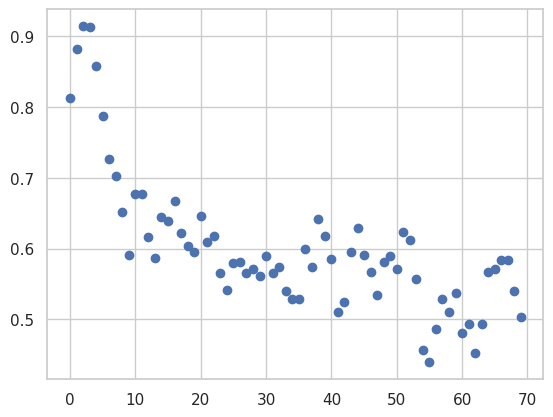

In [53]:
plt.scatter(range(len(astats[:70])), astats[:70])

<Figure size 1000x600 with 0 Axes>

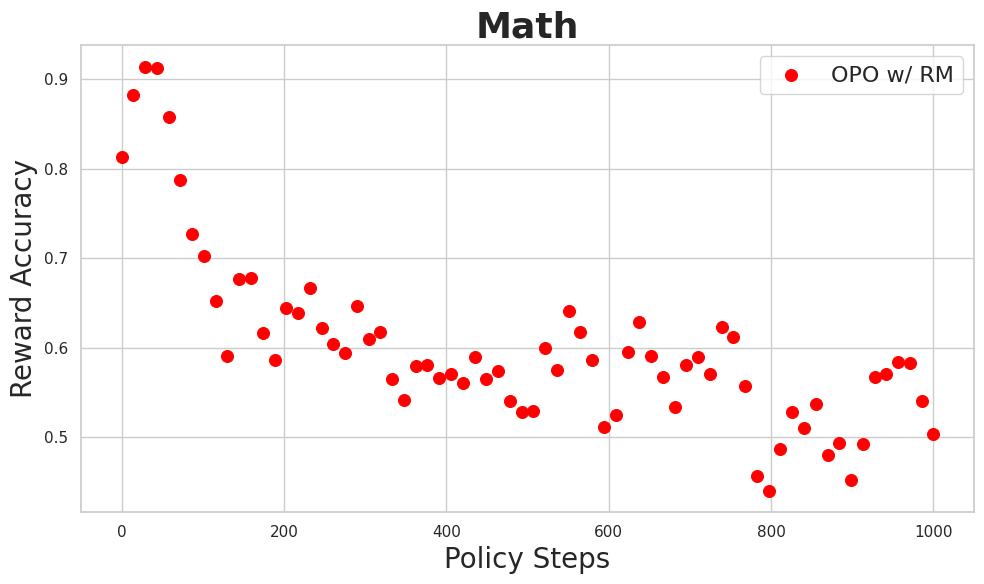

In [55]:
plot_methods({"OPO w/ RM": (0.5, astats[:70])}, xlabel="Policy Steps", ylabel="Reward Accuracy", setname="Math", fname ='mathoffacc.pdf')